# eqc-models

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qci-wdyk/eqc-models-tutorial/blob/main/tutorial01-programming.ipynb)
## Pseudocode for optimization
```
# Define a model instance
instance = OptModel()
# define a solver instance
solver = Solver()
# request a solution
response = solver.solve(model)
display_results(response)
```

## Pseudocode for machine learning
```
# Define a model instance
instance = MLModel()
# fit to training data
instance.fit(knownX, knownY)
# make predictions
y = instance.predict(unownX)
```



# Simple Optimization Model
## Two variable polynomial

$$
-x^2+2xy-y^2
$$

## Imports

In [17]:
# If using this in Google Colab, we need to install the required packages
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install eqc-models==0.12.0

In [9]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from eqc_models.base import PolynomialModel
from eqc_models.solvers.qciclient import Dirac1CloudSolver, Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver

## Visualize

In [10]:
numpoints = 20
xlist = np.linspace(0, 1, numpoints)
ylist = np.linspace(0, 1, numpoints)
x, y = np.meshgrid(xlist, ylist)

In [11]:
z = -x**2 + 2*x*y - y**2

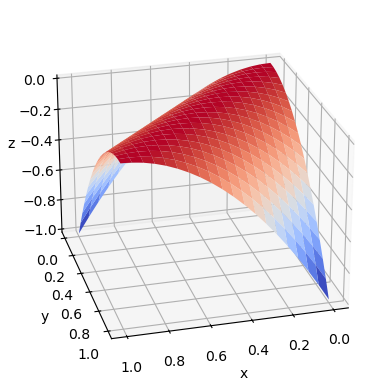

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
polycollection = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(25, 75)

## Model Definition

In [13]:
coefficients = [-1, 2, -1]
indices = [(0, 1), (1, 2), (0, 2)]

In [14]:
model = PolynomialModel(coefficients, indices)
model.upper_bound = np.ones((2, ))

## Dirac-3

In [15]:
solver = Dirac3IntegerCloudSolver()

In [16]:
response = solver.solve(model)

ValueError: must specify url argument or QCI_API_URL environment variable

In [ ]:
response["results"]["solutions"]

[[1, 0]]

In [ ]:
response = solver.solve(model, num_samples=5)

2025-03-15 10:12:40 - Dirac allocation balance = 0 s (unmetered)
2025-03-15 10:12:40 - Job submitted: job_id='67d5a6f800e804f113aefcbb'
2025-03-15 10:12:41 - QUEUED
2025-03-15 10:12:43 - RUNNING
2025-03-15 10:12:49 - COMPLETED
2025-03-15 10:12:52 - Dirac allocation balance = 0 s (unmetered)


In [ ]:
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

Solutions: [[1, 0], [0, 1]] Counts: [3, 2]


In [ ]:
solver = Dirac1CloudSolver()
response = solver.solve(model, num_samples=5)
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

2025-03-15 10:12:54 - Dirac allocation balance = 0 s (unmetered)
2025-03-15 10:12:55 - Job submitted: job_id='67d5a70700e804f113aefcbc'
2025-03-15 10:12:55 - RUNNING
2025-03-15 10:14:01 - COMPLETED
2025-03-15 10:14:04 - Dirac allocation balance = 0 s (unmetered)
Solutions: [[0, 1], [1, 0]] Counts: [3, 2]


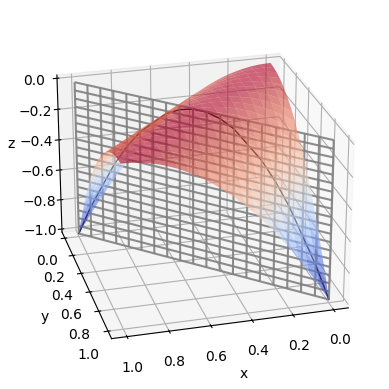

In [ ]:
xsel = np.linspace(0, 1, numpoints)
zsel = np.linspace(-1, 0, numpoints)
xsel, zsel = np.meshgrid(xsel, zsel)
ysel = 1 - xsel
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
polycollection1 = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.6)
polycollection2 = ax.plot_wireframe(xsel, ysel, zsel, color='gray', alpha=0.9)
sel = x + y == 1
xsel = x[sel]
ysel = y[sel]
zsel = z[sel]
ax.plot(xsel, ysel, zsel, linewidth=1, color='black')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(25, 75)

In [ ]:
solver = Dirac3ContinuousCloudSolver()
response = solver.solve(model, sum_constraint=1, relaxation_schedule=1, num_samples=5, solution_precision=0.1)
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

2025-03-15 10:14:07 - Dirac allocation balance = 0 s (unmetered)
2025-03-15 10:14:07 - Job submitted: job_id='67d5a74f00e804f113aefcbd'
2025-03-15 10:14:07 - QUEUED
2025-03-15 10:14:09 - RUNNING
2025-03-15 10:15:13 - COMPLETED
2025-03-15 10:15:16 - Dirac allocation balance = 0 s (unmetered)
Solutions: [[1, 0], [0, 1]] Counts: [4, 1]


# Simple Classification Model

| X1 | X2 | Y |
|----|----|---|
| 0.25 | 0.25 | -1 |
| 0.75 | 0.25 | -1 |
| 0.75 | 0.75 | 1 |
| 0.5 | 0 | -1 |
| 0.5 | 1 | 1 |
| 1 | 1 | 1 |

In [15]:
from eqc_models.ml.classifierqboost import QBoostClassifier

In [16]:
X = np.array([[ 0.25, 0.25],
              [0.75, 0.25],
              [0.75, 0.75],
              [0.5, 0],
              [0.5, 1],
             [1, 1]])
y = np.array([-1, -1, 1, -1, 1, 1])

In [17]:
qboost = QBoostClassifier(num_samples=1,relaxation_schedule=1,lambda_coef=0.0, weak_cls_strategy="sequential")

In [18]:
qboost.fit(X, y)

Runtime of _build_weak_classifiers_sq: 0.02 seconds!
Built 3 weak classifiers!
Runtime of get_hamiltonian: 0.02 seconds!
2025-03-15 10:15:20 - Dirac allocation balance = 0 s (unmetered)
2025-03-15 10:15:20 - Job submitted: job_id='67d5a79800e804f113aefcbe'
2025-03-15 10:15:20 - QUEUED
2025-03-15 10:15:23 - RUNNING
2025-03-15 10:15:31 - COMPLETED
2025-03-15 10:15:33 - Dirac allocation balance = 0 s (unmetered)
{'job_info': {'job_id': '67d5a79800e804f113aefcbe', 'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '67d5a797236cc2225ac90cd9'}}, 'device_config': {'dirac-3_normalized_qudit': {'num_samples': 1, 'relaxation_schedule': 1, 'solution_precision': 1, 'sum_constraint': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-03-15T16:15:20.555Z', 'queued_at_rfc3339nano': '2025-03-15T16:15:20.555Z', 'running_at_rfc3339nano': '2025-03-15T16:15:20.919Z', 'completed_at_rfc3339nano': '2025-03-15T16:15:30.624Z'}, 'job_result': {'file_id'

{'job_info': {'job_id': '67d5a79800e804f113aefcbe',
  'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '67d5a797236cc2225ac90cd9'}},
   'device_config': {'dirac-3_normalized_qudit': {'num_samples': 1,
     'relaxation_schedule': 1,
     'solution_precision': 1,
     'sum_constraint': 1}}},
  'job_status': {'submitted_at_rfc3339nano': '2025-03-15T16:15:20.555Z',
   'queued_at_rfc3339nano': '2025-03-15T16:15:20.555Z',
   'running_at_rfc3339nano': '2025-03-15T16:15:20.919Z',
   'completed_at_rfc3339nano': '2025-03-15T16:15:30.624Z'},
  'job_result': {'file_id': '67d5a7a2236cc2225ac90cdb', 'device_usage_s': 1}},
 'status': 'COMPLETED',
 'results': {'counts': [1],
  'energies': [-6],
  'solutions': [[8.76e-05, 0.4723995, 0.5275128]],
  'distilled_energies': [-6],
  'distilled_solutions': [[0, 1, 0]]}}

In [19]:
qboost.predict(X), y

(array([-1., -1.,  1., -1.,  1.,  1.]), array([-1, -1,  1, -1,  1,  1]))

In [20]:
qboost.predict(np.array([[1, 1], [0.2, 0.2], [0.6, 0.75], [1, 0], [0.6, 0.6]]))

array([ 1., -1.,  1., -1.,  1.])